# State Estimation, Forward-Backward

In this demo, we will perform state estimation in a state-space model (SSM) using the ForneyLab toolbox. The goal is to estimate a hidden state from noisy scalar observations.

\begin{align*}
    u &= 1\\
    n_t &\sim \mathcal{N}(0, v)\\
    x_t &= x_{t-1} + u\\
    y_t &= x_t + n_t
\end{align*}

We further assume that the observations are corrupted by i.i.d. Gaussian noise with variance `v`. 

The SSM can be represented as a Forney-style factor graph:

```
                 (u)
                  |
    (x_t_min) --> + --> = --> (x_t)
                        |    
               (n_t)--> +
                        |
                      (y_t)
```

The full generative model is obtained by chaining multiple of these sections.

In [11]:
# Data
n_samples = 100
x_data = [t for t=1:n_samples] # True state
y_data = x_data + sqrt(200.0)*randn(n_samples); # Noisy observations of state

# Build

In [12]:
using ForneyLab

g = FactorGraph()

# Prior statistics
m_x_0 = Variable(id=:m_x_0)
v_x_0 = Variable(id=:v_x_0)

# State prior
x_0 ~ GaussianMeanVariance(m_x_0, v_x_0)

# Transition and observation model
x = Vector{Variable}(n_samples)
y = Vector{Variable}(n_samples)

x_t_min = x_0
for t = 1:n_samples
    u_t = constant(1.0)
    n_t ~ GaussianMeanVariance(constant(0.0), constant(200.0)) # zero-mean gaussian observation noise
    x[t] = x_t_min + u_t
    y[t] = x[t] + n_t

    # Data placeholder
    placeholder(y[t], :y, index=t)
    
    # Reset state for next step
    x_t_min = x[t]
end

# Placeholders for prior statistics
placeholder(m_x_0, :m_x_0)
placeholder(v_x_0, :v_x_0)

# Name variable for ease of lookup
for t = 1:n_samples
    x[t].id = :x_*t
    y[t].id = :y_*t    
end

# Schedule

Now that the factor graph is complete, we can generate an algorithm that computes the current state from the previous state prior and the currently observed data point.

In [13]:
algo = sumProductAlgorithm(x); # Figure out a schedule and compile to Julia code

# Infer

All set. Now we apply the filter by recurively applying the forward algorithm to the data. 

In [16]:
# Define algorithm
eval(parse(algo))

# Prepare data dictionary and prior statistisc
data = Dict(:y     => y_data,
            :m_x_0 => 0.0,
            :v_x_0 => 1000.0)

# Execute algorithm
marginals = step!(data)

# Extract posterior statistics
m_x = [mean(marginals[:x_*t]) for t = 1:n_samples]
v_x = [var(marginals[:x_*t]) for t = 1:n_samples];

# Results

That was easy!
Let's plot the filter output (mean and standard deviation of `x_t`) together with the noisy observations to see if it worked.

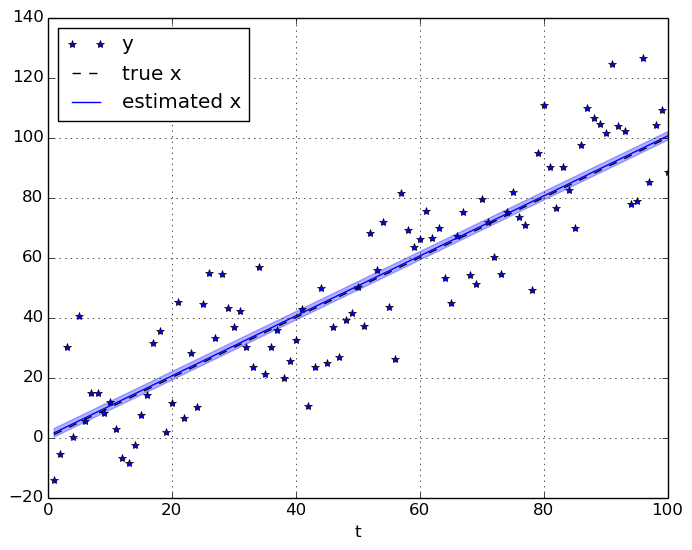

/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


In [17]:
using PyPlot

plot(collect(1:n_samples), y_data, "b*", label="y")
plot(collect(1:n_samples), x_data, "k--", label="true x")
plot(collect(1:n_samples), m_x, "b-", label="estimated x")
fill_between(collect(1:n_samples), m_x-sqrt(v_x), m_x+sqrt(v_x), color="b", alpha=0.3);
grid("on")
xlabel("t")
legend(loc="upper left");